In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests, glob, Augmentor, os, json, pickle, matplotlib, keras, sklearn
from zipfile import ZipFile
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Dense, Flatten
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.applications.vgg19 import VGG19, preprocess_input
from keras import optimizers
from keras import backend as K

from keras.callbacks import TensorBoard
from keras.callbacks import TerminateOnNaN
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger
from keras.callbacks import History

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Versions

print('Versions')
print('Numpy:', np.__version__)
print('Matplotlib:', matplotlib.__version__)
print('Tensorflow:', tf.__version__)
print('Keras:', keras.__version__)
print('Sklearn:', sklearn.__version__)

Versions
Numpy: 1.14.2
Matplotlib: 2.2.2
Tensorflow: 1.7.0
Keras: 2.1.5
Sklearn: 0.19.1


In [3]:
def download_file(url, out_file):
    chunk_size = 1024
    r = requests.get(url, stream=True)
    total_size = int(r.headers['content-length'])
    with open(out_file, 'wb') as f:
        for data in tqdm(iterable=r.iter_content(chunk_size=chunk_size),
                         total=total_size/chunk_size, unit='KB'):
            f.write(data)
    print('{} download Complete!'.format(out_file))

def extract_zipfile(data_path, zip_file):
    if not os.path.isdir(data_path):
        with ZipFile(zip_file, 'r') as f:
            print('Extracting all the files now ...')
            f.extractall(data_path)
            print('Done!')

def explore_data(data_path, labels_list):
    images_count = []
    X = []
    y = []
    plt.figure(1)
    print('No of images in:')
    for idx, label in enumerate(labels_list):
        label_path = os.path.join(data_path, label)
        images_list = glob.glob(os.path.join(label_path, '*.png'))
        num_images = len(images_list)
        images_count.append(num_images)
        X += images_list
        y += [label] * num_images
        img_path = images_list[0]
        img = plt.imread(img_path)

        plt.subplot(3,4,idx+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
        print('{} directory: {}'.format(label, num_images))
    print()
    plt.show()
    return images_count, X, y

def plot_histogram(y):
    plt.hist(y, bins=86)
    plt.xlabel('labels')
    plt.ylabel('no of images')
    plt.show()

def augment_images(path, num, avg_img):
    p = Augmentor.Pipeline(path, '.', save_format='png')
    p.random_brightness(.5, .25, .75)
    p.random_color(.5, .25, .75)
    p.random_contrast(.5, .25, .75)
    p.rotate(.5, 10, 10)
    p.sample(avg_img - num)

def add_dicts(d, e):
    for key in e.keys():
        if key not in d:
            d[key] = e[key]
        else:
            d[key] += e[key]
    return d

def plot_metrics(d):
    plots = [i for i in d.keys() if i.find('val_') == -1]
    plt.figure(figsize=(15,25))
    for i, p in enumerate(plots):
        plt.subplot(len(plots), 2, i+1)
        plt.title(p)
        plt.plot(d[p], label=p)
        plt.plot(d['val_'+p], label = 'val_'+p)
        plt.legend()
    plt.show()

def precision(y_true, y_pred):
    tp = K.sum(y_true * y_pred)
    fp = K.sum(y_pred * K.cast(K.equal(y_true, K.zeros_like(y_true)), "float32"))
    return tp / (tp + fp + K.epsilon())

def recall(y_true, y_pred):
    tp = K.sum(y_true * y_pred)
    fn = K.sum(y_true * K.cast(K.equal(y_pred, K.zeros_like(y_pred)), "float32"))
    return tp / (tp + fn + K.epsilon())

def f1(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred = K.one_hot(y_pred, 12)
    pm = precision(y_true, y_pred)
    rm = recall(y_true, y_pred)
    return (2 * pm * rm) / (pm + rm + K.epsilon())

def get_callbacks():
    # TerminateOnNaN
    terminate_callback = TerminateOnNaN()
    # Tensorboard
    tb_callback = TensorBoard('./Graph', histogram_freq=0,
                    write_graph=True, write_images=True)
    # Model Checkppoint
    ckpt_callback = ModelCheckpoint('./output_data/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                    verbose=1, save_weights_only=False,
                                    mode='auto', period=5)
    # CSV Logger
    csv_logger = CSVLogger('./training.log')
    # History
    hist = History()
    # Callbacks list
    callbacks = [terminate_callback, tb_callback, ckpt_callback,
                 csv_logger, hist]
    return callbacks

def data_generator(X, y, batch_size):
    idx = 0
    encoder = LabelBinarizer()
    y = encoder.fit_transform(y)
    num_batches = len(X)//batch_size
    while True:
        start = idx * batch_size
        end = start + batch_size
        batch_X = []
        batch_y = y[start:end, :]
        for filename in X[start:end]:
            img = image.load_img(filename, target_size=(299, 299, 3))
            img = image.img_to_array(img)
            batch_X.append(img)
        batch_X = np.array(batch_X)
        batch_X = preprocess_input(batch_X)
        batch_X /= 255
        idx += 1
        yield batch_X, batch_y
        if idx == num_batches:
            idx = 0

def get_model(lr):
    # Load model
    # include_top is used to remove all the layers after block conv5

    model = VGG19(include_top=False, input_shape=(299, 299, 3))

    # Freeze all layers
    for layer in model.layers:
        layer.trainable = False

    # re-add the removed layers
    x = model.output
    x = Flatten(name="flatten")(x)
    x = Dense(4096, activation="relu", name="fc1")(x)
    x = Dense(4096, activation="relu", name="fc2")(x)
    x = Dense(num_labels, activation="softmax", name="predictions")(x)

    # Redefine the model
    model = Model(inputs=model.input, outputs=x, name="final_model")

    model.summary()

    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, 
                           epsilon=1e-08, decay=0.0)

    # compile the model
    model.compile(optimizer=adam, loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall,
              f1])

    return model

In [4]:
url = 'https://vision.eng.au.dk/?download=/data/WeedData/NonsegmentedV2.zip'
zip_file = './data.zip'
data_path = './data'

if not os.path.isfile(zip_file):
    download_file(url, zip_file)

In [5]:
ls

data.zip  Plant Seedlings.ipynb


In [6]:
extract_zipfile(data_path, zip_file)

Extracting all the files now ...
Done!


In [7]:
ls

data/  data.zip  Plant Seedlings.ipynb


In [8]:
ls data/

Black-grass/  Common Chickweed/  Loose Silky-bent/   Shepherd’s Purse/
Charlock/     Common wheat/      Maize/              Small-flowered Cranesbill/
Cleavers/     Fat Hen/           Scentless Mayweed/  Sugar beet/


In [9]:
labels_list = os.listdir(data_path)
num_labels = len(labels_list)

print('Labels:')

for idx, label in enumerate(labels_list):
    print('{}. {}'.format(idx+1, label))

Labels:
1. Shepherd’s Purse
2. Cleavers
3. Maize
4. Fat Hen
5. Black-grass
6. Charlock
7. Sugar beet
8. Small-flowered Cranesbill
9. Common wheat
10. Loose Silky-bent
11. Scentless Mayweed
12. Common Chickweed


No of images in:
Shepherd’s Purse directory: 274
Cleavers directory: 335
Maize directory: 257
Fat Hen directory: 538
Black-grass directory: 309
Charlock directory: 452
Sugar beet directory: 463
Small-flowered Cranesbill directory: 576
Common wheat directory: 253
Loose Silky-bent directory: 762
Scentless Mayweed directory: 607
Common Chickweed directory: 713



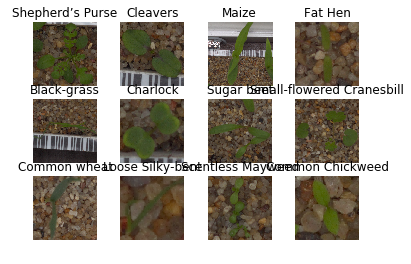

In [10]:
images_count, _, y = explore_data(data_path, labels_list)

In [11]:
avg_img = sum(images_count)//len(images_count)

print(avg_img)

461


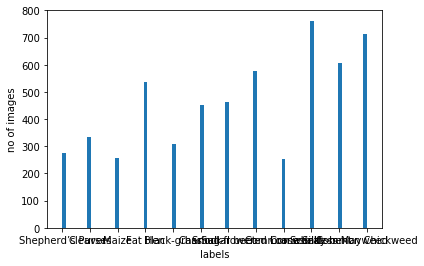

In [12]:
plot_histogram(y)

In [13]:
from subprocess import call

if not os.path.isdir('./data_copy'):
    _ = call(['cp', '-a', data_path, './data_copy'])

data_path = './data_copy'

In [14]:
ls

data/  data_copy/  data.zip  Plant Seedlings.ipynb


In [15]:
if len(os.listdir('./data_copy/Black-grass')) < avg_img+1:    
    for label in labels_list:
        label_path = os.path.join(data_path, label)
        images_list = os.listdir(label_path)
        if len(images_list) < avg_img:
            augment_images(label_path, len(images_list), avg_img) 

Executing Pipeline:   0%|          | 0/187 [00:00<?, ? Samples/s]

Initialised with 274 image(s) found.
Output directory set to ./data_copy/Shepherd’s Purse/..

Processing <PIL.Image.Image image mode=RGB size=191x191 at 0x7FD7073E22B0>: 100%|██████████| 187/187 [00:03<00:00, 54.90 Samples/s]                
Executing Pipeline:   0%|          | 0/126 [00:00<?, ? Samples/s]

Initialised with 335 image(s) found.
Output directory set to ./data_copy/Cleavers/..

Processing <PIL.Image.Image image mode=RGB size=428x428 at 0x7FD70747C940>: 100%|██████████| 126/126 [00:01<00:00, 92.49 Samples/s]                
Processing <PIL.Image.Image image mode=RGB size=114x114 at 0x7FD707442630>:   0%|          | 1/204 [00:00<00:33,  6.09 Samples/s]

Initialised with 257 image(s) found.
Output directory set to ./data_copy/Maize/..

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=142x142 at 0x7FD70743EFD0>: 100%|██████████| 204/204 [00:09<00:00, 22.31 Samples/s]  
Executing Pipeline:   0%|          | 0/152 [00:00<?, ? Samples/s]

Initialised with 309 image(s) found.
Output directory set to ./data_copy/Black-grass/..

Processing <PIL.Image.Image image mode=RGB size=1009x1009 at 0x7FD70743AF60>: 100%|██████████| 152/152 [00:12<00:00, 11.75 Samples/s]                
Processing <PIL.Image.Image image mode=RGB size=441x441 at 0x7FD70743A898>:  11%|█         | 1/9 [00:00<00:01,  5.29 Samples/s]

Initialised with 452 image(s) found.
Output directory set to ./data_copy/Charlock/..

Processing <PIL.Image.Image image mode=RGB size=238x238 at 0x7FD707469470>: 100%|██████████| 9/9 [00:00<00:00, 10.94 Samples/s]
Executing Pipeline:   0%|          | 0/208 [00:00<?, ? Samples/s]

Initialised with 253 image(s) found.
Output directory set to ./data_copy/Common wheat/..

Processing <PIL.Image.Image image mode=RGB size=189x189 at 0x7FD707425160>: 100%|██████████| 208/208 [00:06<00:00,  5.98 Samples/s]                  


No of images in:
Shepherd’s Purse directory: 461
Cleavers directory: 461
Maize directory: 461
Fat Hen directory: 538
Black-grass directory: 461
Charlock directory: 461
Sugar beet directory: 463
Small-flowered Cranesbill directory: 576
Common wheat directory: 461
Loose Silky-bent directory: 762
Scentless Mayweed directory: 607
Common Chickweed directory: 713



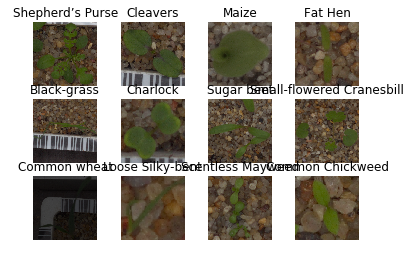

In [16]:
_, X, y = explore_data(data_path, labels_list)

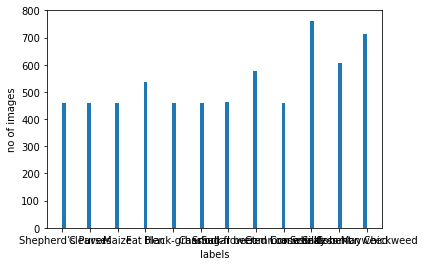

In [17]:
plot_histogram(y)

In [18]:
## Split data

X, y = shuffle(X, y)

X, X_valid, y, y_valid = train_test_split(X, y, test_size=0.1,
                                          random_state=0, stratify=y)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2,
                                        random_state=0, stratify=y)

print('Train:', len(X), len(y))
print('Valid:', len(X_valid), len(y_valid))
print('Test:', len(X_test), len(y_test))

Train: 4625 4625
Valid: 643 643
Test: 1157 1157


In [19]:
output_path = './output_data'
log_file = os.path.join(output_path, 'log.csv')

full_model_path = os.path.join(output_path, 'plant_vgg19.h5')
cross_model_path = os.path.join(output_path, 'plant_vgg19_cross.h5')

if not os.path.exists(output_path):
    os.makedirs(output_path)

In [20]:
n_splits = 3
batch_size = 32
epochs = 10
lr = 0.0001

In [21]:
model = get_model(lr)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0         
__________

In [22]:
## Cross Validation

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

histories = {}

if not os.path.isfile(cross_model_path):

    # Training
    print("Start cross-validation training...")

    temp_X = np.array(X)
    temp_y = np.array(y)

    for train, val in skf.split(temp_X, temp_y):
        train_datagen = data_generator(temp_X[train], temp_y[train], batch_size)
        valid_datagen = data_generator(temp_X[val], temp_y[val], batch_size)

        history = model.fit_generator(train_datagen, steps_per_epoch=len(train)//batch_size,
                    validation_data=valid_datagen, epochs=epochs, 
                                     validation_steps = len(val)//batch_size)
        
        histories = add_dicts(histories, history.history)

    model.save(cross_model_path)
    
    del model
    
    with open('cross_train.pkl', 'wb') as f:
        pickle.dump(histories, f)
        
else:
    with open('cross_train.pkl', 'rb') as f:
        histories = pickle.load(f)    

Start cross-validation training...
Epoch 1/10
96/96 [==============================] - 61s 631ms/step - loss: 2.3606 - acc: 0.2396 - precision: 0.1474 - recall: 1.0000 - f1: 0.2396 - val_loss: 1.8564 - val_acc: 0.3737 - val_precision: 0.2121 - val_recall: 1.0000 - val_f1: 0.3737
Epoch 2/10
96/96 [==============================] - 56s 582ms/step - loss: 1.5530 - acc: 0.4710 - precision: 0.2994 - recall: 1.0000 - f1: 0.4710 - val_loss: 1.5159 - val_acc: 0.4779 - val_precision: 0.3222 - val_recall: 1.0000 - val_f1: 0.4779
Epoch 3/10
96/96 [==============================] - 56s 583ms/step - loss: 1.1555 - acc: 0.6074 - precision: 0.4406 - recall: 1.0000 - f1: 0.6074 - val_loss: 1.2980 - val_acc: 0.5469 - val_precision: 0.4032 - val_recall: 1.0000 - val_f1: 0.5469
Epoch 4/10
96/96 [==============================] - 56s 583ms/step - loss: 0.9329 - acc: 0.6758 - precision: 0.5365 - recall: 1.0000 - f1: 0.6758 - val_loss: 1.1957 - val_acc: 0.5794 - val_precision: 0.4572 - val_recall: 1.0000 - 

In [23]:
with open('cross_train.pkl', 'rb') as f:
    histories = pickle.load(f)  

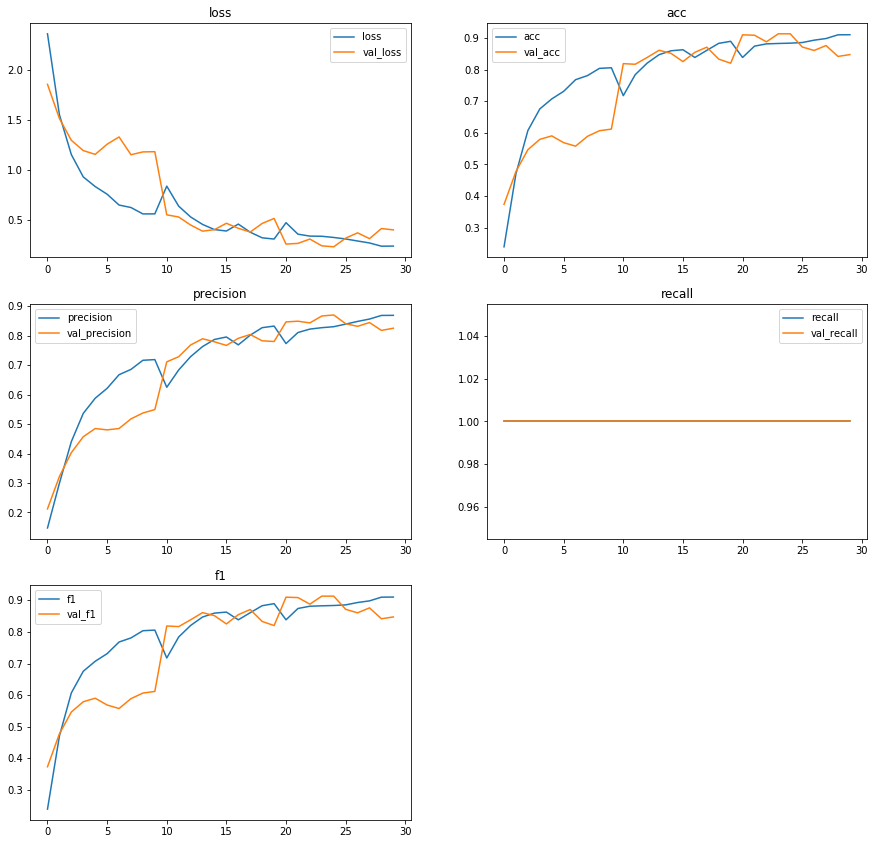

In [24]:
plot_metrics(histories)

In [25]:
callbacks = get_callbacks()

Instructions for updating:
Use the retry module or similar alternatives.


In [26]:
## Full Training

batch_size = 32
epochs = 20

model = load_model(cross_model_path, custom_objects={'f1':f1, 'precision':precision, 
                                                     'recall':recall})

if not os.path.isfile(full_model_path):

    print("Full training...")

    train_datagen = data_generator(X, y, batch_size)
    valid_datagen = data_generator(X_valid, y_valid, batch_size)

    history = model.fit_generator(train_datagen, steps_per_epoch=len(X)//batch_size,
                        epochs=epochs, callbacks = callbacks,
                        validation_data=valid_datagen, validation_steps=len(X_valid)//batch_size)

    histories = add_dicts(histories, history.history)

    print("Save whole model...")
    model.save(full_model_path)
    
    with open('full_train.pkl', 'wb') as f:
        pickle.dump(histories, f)
        
else:
    with open('full_train.pkl', 'rb') as f:
        histories = pickle.load(f)  

Full training...
Epoch 1/20
144/144 [==============================] - 69s 476ms/step - loss: 0.2600 - acc: 0.9054 - precision: 0.8628 - recall: 1.0000 - f1: 0.9054 - val_loss: 1.3114 - val_acc: 0.6687 - val_precision: 0.6403 - val_recall: 1.0000 - val_f1: 0.6687
Epoch 2/20
144/144 [==============================] - 68s 475ms/step - loss: 0.2340 - acc: 0.9151 - precision: 0.8761 - recall: 1.0000 - f1: 0.9151 - val_loss: 1.4996 - val_acc: 0.6359 - val_precision: 0.6228 - val_recall: 1.0000 - val_f1: 0.6359
Epoch 3/20
144/144 [==============================] - 68s 474ms/step - loss: 0.2291 - acc: 0.9178 - precision: 0.8794 - recall: 1.0000 - f1: 0.9178 - val_loss: 1.3911 - val_acc: 0.6734 - val_precision: 0.6528 - val_recall: 1.0000 - val_f1: 0.6734
Epoch 4/20
144/144 [==============================] - 68s 473ms/step - loss: 0.2324 - acc: 0.9171 - precision: 0.8797 - recall: 1.0000 - f1: 0.9171 - val_loss: 1.2287 - val_acc: 0.6797 - val_precision: 0.6560 - val_recall: 1.0000 - val_f1: 0.

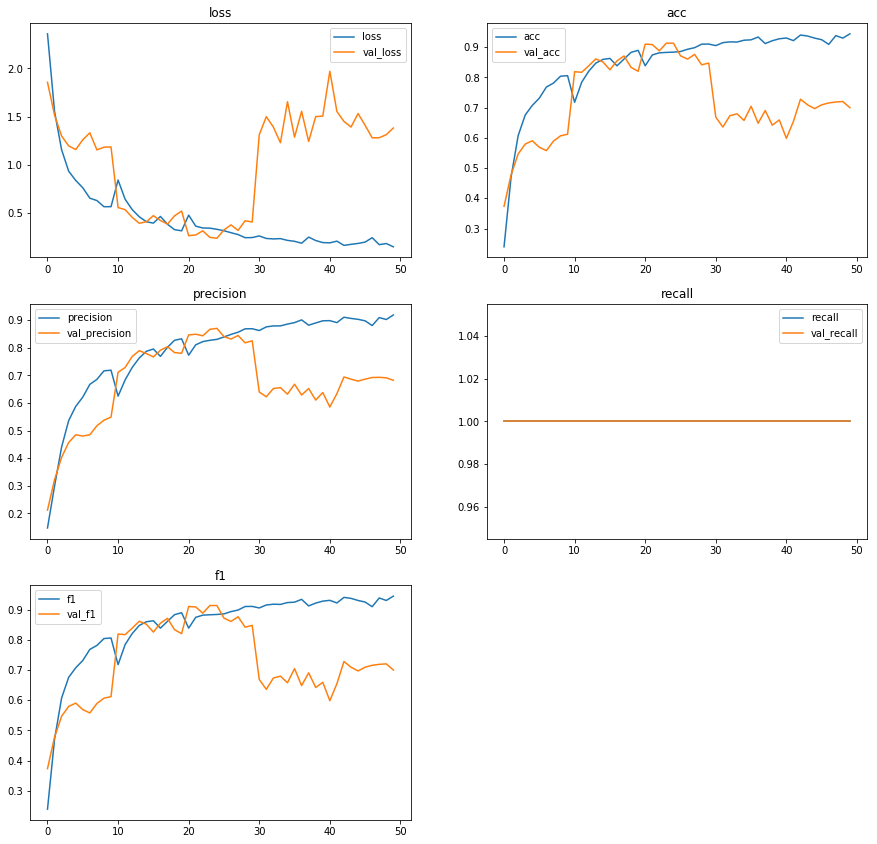

In [27]:
plot_metrics(histories)

In [28]:
## Evaluate

batch_size = 32

model = load_model(full_model_path, custom_objects={'f1':f1, 'precision':precision, 
                                                     'recall':recall})

test_datagen = data_generator(X_test, y_test, batch_size)

Eval = model.evaluate_generator(test_datagen, steps = len(X_test)//batch_size, workers=12)    
print(Eval)

[1.2874099049303267, 0.7109375, 0.687002480857902, 1.0, 0.7109374403953552]
